##  Answering Business Questions using SQL

### Question 1: What albums should we order?

We need to analysis our sales data by genre and see which genres are popular, then decide to order 3 of these 4 albums:

**Artist Name	\ Genre**
- Regal \ Hip-Hop
- Red Tone \ Punk
- Meteor and the Girls \ Pop
- Slim Jim Bites \ Blues

In [1]:
#load SQL for queries, pandas for dataframes, and matplotlib for charts
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#make plots show in notebook
%matplotlib inline

Let's try a basic query of the database using a simple connection which we'll close as soon as we've run the query.

In [2]:
#open connection to database and test a query
conn = sql.connect("Data/chinook.db")
query = 'SELECT first_name || " " || last_name name FROM customer LIMIT 10'
result = conn.execute(query).fetchall()
conn.close()

print(result)

[('Luís Gonçalves',), ('Leonie Köhler',), ('François Tremblay',), ('Bjørn Hansen',), ('František Wichterlová',), ('Helena Holý',), ('Astrid Gruber',), ('Daan Peeters',), ('Kara Nielsen',), ('Eduardo Martins',)]


In [3]:
#function to query database safely
def run_query(q):
    #open connection with context manager to ensure db not left open
    with sql.connect('Data/chinook.db') as conn:
        #return query as a pandas dataframe instead of text output
        result = pd.read_sql(q, conn)
        return result

In [4]:
#function to run commands on database that dont require a query (crate view, etc)
def run_command(c):
    with sql.connect('Data/chinook.db') as conn:
        #auto commit any changes
        conn.isolation_level = None
        conn.execute(c)

In [5]:
#function to show all tables and views in the database currently
def show_tables():
    query = 'SELECT name, type FROM sqlite_master WHERE type IN ("table","view");'
    return run_query(query)

In [6]:
data = show_tables()
print(data)

              name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table


In [7]:
genres_sold = """
SELECT g.name genre, COUNT(il.quantity) quantity, CAST(COUNT(il.quantity) as float)/CAST((SELECT SUM(quantity) FROM invoice_line) as float) percentage FROM track t 
LEFT JOIN genre g ON g.genre_id = t.genre_id 
LEFT JOIN invoice_line il ON il.track_id = t.track_id 
GROUP BY genre ORDER BY quantity DESC 
"""

genres_analysis = run_query(genres_sold)
print(genres_analysis)

                 genre  quantity  percentage
0                 Rock      2635    0.553921
1                Metal       619    0.130124
2   Alternative & Punk       492    0.103427
3                Latin       167    0.035106
4             R&B/Soul       159    0.033424
5                Blues       124    0.026067
6                 Jazz       121    0.025436
7          Alternative       117    0.024595
8       Easy Listening        74    0.015556
9                  Pop        63    0.013244
10   Electronica/Dance        55    0.011562
11           Classical        47    0.009880
12              Reggae        35    0.007358
13         Hip Hop/Rap        33    0.006937
14         Heavy Metal         8    0.001682
15          Soundtrack         5    0.001051
16            TV Shows         2    0.000420
17               Drama         1    0.000210
18               World         0    0.000000
19     Science Fiction         0    0.000000
20    Sci Fi & Fantasy         0    0.000000
21       R

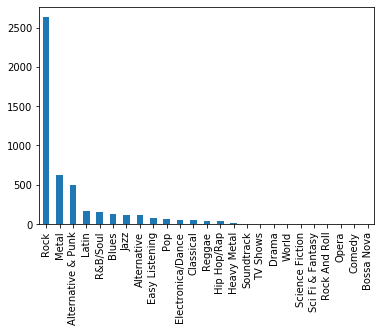

In [8]:
genre_plot = genres_analysis['quantity'].plot.bar().set_xticklabels(genres_analysis['genre'])

It looks like Rock, Metal, and Punk are the best selling genres in the USA. Since we dont have an endless list of albums to order from for this exercise, we'd choose to order:

- Red Tone, Punk, first
- Slim Jim Bites, Blues, next
- Meteor and the Girls, Pop, last

The hip-hop album sales aren't doing great comparatively so we won't order that one. 

### Hows Employee Performance?

Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that you find are relevant to the analysis.

In [9]:
total_sales_query = """
SELECT 
    e1.first_name || " " || e1.last_name name, 
    e1.hire_date, 
    e2.first_name || " " || e2.last_name reports_to, 
    SUM(i.total) total_sales 
FROM employee e1
LEFT JOIN customer c ON e1.employee_id = c.support_rep_id
LEFT JOIN invoice i ON c.customer_id = i.customer_id
LEFT JOIN employee e2 ON e1.reports_to=e2.employee_id
GROUP BY name
"""

sales_analysis = run_query(total_sales_query)
print(sales_analysis)

               name            hire_date        reports_to  total_sales
0      Andrew Adams  2016-08-14 00:00:00              None          NaN
1      Jane Peacock  2017-04-01 00:00:00     Nancy Edwards      1731.51
2    Laura Callahan  2017-03-04 00:00:00  Michael Mitchell          NaN
3     Margaret Park  2017-05-03 00:00:00     Nancy Edwards      1584.00
4  Michael Mitchell  2016-10-17 00:00:00      Andrew Adams          NaN
5     Nancy Edwards  2016-05-01 00:00:00      Andrew Adams          NaN
6       Robert King  2017-01-02 00:00:00  Michael Mitchell          NaN
7     Steve Johnson  2017-10-17 00:00:00     Nancy Edwards      1393.92


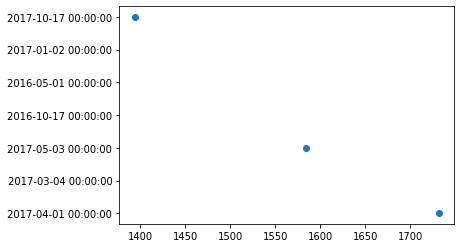

In [10]:
plt.scatter(x=sales_analysis['total_sales'],y=sales_analysis['hire_date'])

There seems to be a correlation between hire date and sales total. However, we have few data points.

### Question 3: What countries do people order from the most?

In particular, we will calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

In [32]:
##total_per_customer_table : calc total amount of sales per customer by country
##
#also add a one_customer column to indicate if the country only has 1 customer
total_per_customer_table = """
WITH total_per_customer AS 
(SELECT c.country, c.last_name, SUM(i.total) total FROM invoice i
LEFT JOIN customer c ON c.customer_id=i.customer_id
GROUP BY c.customer_id
ORDER BY c.country),
avg_sales_by_country AS
(SELECT 
    tpc.country,
    AVG(tpc.total) average_sales_per_customer, 
    CASE
        WHEN COUNT(tpc.country) = 1 THEN 1
        Else 0
    END as one_customer
FROM total_per_customer tpc
GROUP BY tpc.country)

SELECT * FROM avg_sales_by_country
"""
country_analysis = run_query(total_per_customer_table)
print(country_analysis)

           country  average_sales_per_customer  one_customer
0        Argentina                   39.600000             1
1        Australia                   81.180000             1
2          Austria                   69.300000             1
3          Belgium                   60.390000             1
4           Brazil                   85.536000             0
5           Canada                   66.948750             0
6            Chile                   97.020000             1
7   Czech Republic                  136.620000             0
8          Denmark                   37.620000             1
9          Finland                   79.200000             1
10          France                   77.814000             0
11         Germany                   83.655000             0
12         Hungary                   78.210000             1
13           India                   91.575000             0
14         Ireland                  114.840000             1
15           Italy      

Now let's see if we can calculate an 'Other' column consisting of all the countries with only 1 customer. We'll reuse our subqueries from above.

In [36]:
country_query = """
WITH total_per_customer AS 
(SELECT c.country, c.last_name, SUM(i.total) total FROM invoice i
LEFT JOIN customer c ON c.customer_id=i.customer_id
GROUP BY c.customer_id
ORDER BY c.country),
avg_sales_by_country AS
(SELECT 
    tpc.country,
    AVG(tpc.total) average_sales_per_customer, 
    CASE
        WHEN COUNT(tpc.country) = 1 THEN 1
        Else 0
    END as one_customer
FROM total_per_customer tpc
GROUP BY tpc.country)


SELECT 
    CASE
        WHEN asc.one_customer = 1 THEN 'Other'
        Else c.country
    END as Countries_Other,
    COUNT(DISTINCT(c.customer_id)) total_customers,
    SUM(i.total) total_sales, 
    asc.average_sales_per_customer,
    AVG(i.total) avg_order_value
FROM invoice i
LEFT JOIN customer c ON c.customer_id=i.customer_id
LEFT JOIN avg_sales_by_country asc ON asc.country=c.country
GROUP BY Countries_Other
"""

country_analysis_other = run_query(country_query)
print(country_analysis_other)

  Countries_Other  total_customers  total_sales  average_sales_per_customer  \
0          Brazil                5       427.68                   85.536000   
1          Canada                8       535.59                   66.948750   
2  Czech Republic                2       273.24                  136.620000   
3          France                5       389.07                   77.814000   
4         Germany                4       334.62                   83.655000   
5           India                2       183.15                   91.575000   
6           Other               15      1094.94                   76.230000   
7        Portugal                2       185.13                   92.565000   
8             USA               13      1040.49                   80.037692   
9  United Kingdom                3       245.52                   81.840000   

   avg_order_value  
0         7.011148  
1         7.047237  
2         9.108000  
3         7.781400  
4         8.161463  
5   

Lastly we will re-order everything so that the 'Other' column is at the bottom. We'll copy our work from above again.

In [43]:
country_query = """
WITH total_per_customer AS 
(SELECT c.country, c.last_name, SUM(i.total) total FROM invoice i
LEFT JOIN customer c ON c.customer_id=i.customer_id
GROUP BY c.customer_id
ORDER BY c.country),
avg_sales_by_country AS
(SELECT 
    tpc.country,
    AVG(tpc.total) average_sales_per_customer, 
    CASE
        WHEN COUNT(tpc.country) = 1 THEN 1
        Else 0
    END as one_customer
FROM total_per_customer tpc
GROUP BY tpc.country),
combined_view AS
(SELECT 
    CASE
        WHEN asc.one_customer = 1 THEN 'Other'
        Else c.country
    END as country_name,
    COUNT(DISTINCT(c.customer_id)) total_customers,
    SUM(i.total) total_sales, 
    asc.average_sales_per_customer,
    AVG(i.total) avg_order_value
FROM invoice i
LEFT JOIN customer c ON c.customer_id=i.customer_id
LEFT JOIN avg_sales_by_country asc ON asc.country=c.country
GROUP BY country_name)

SELECT country_name, total_customers, total_sales, average_sales_per_customer, avg_order_value FROM 
( 
SELECT cv.*, 
    CASE
        WHEN cv.country_name = 'Other' THEN 1
        ELSE 0
    END AS sort
FROM combined_view cv
)
ORDER BY sort ASC
"""

country_analysis_other = run_query(country_query)
print(country_analysis_other)

     country_name  total_customers  total_sales  average_sales_per_customer  \
0          Brazil                5       427.68                   85.536000   
1          Canada                8       535.59                   66.948750   
2  Czech Republic                2       273.24                  136.620000   
3          France                5       389.07                   77.814000   
4         Germany                4       334.62                   83.655000   
5           India                2       183.15                   91.575000   
6        Portugal                2       185.13                   92.565000   
7             USA               13      1040.49                   80.037692   
8  United Kingdom                3       245.52                   81.840000   
9           Other               15      1094.94                   76.230000   

   avg_order_value  
0         7.011148  
1         7.047237  
2         9.108000  
3         7.781400  
4         8.161463  
5   

Test with VIEWs next time to see if they persist between cells. Ex:

c = '''
CREATE VIEW top_5_names AS
     SELECT
         first_name,
         count(customer_id) count
     FROM customer
     GROUP by 1
     ORDER by 2 DESC
     LIMIT 5;
'''
run_command(c)

**Now let's visualize these results!**

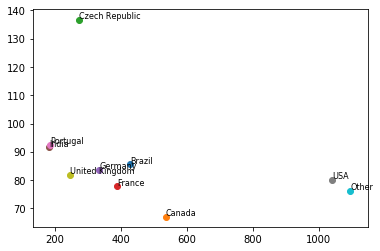

In [77]:
#scatter plot total sales by average sales per customer, grouped by country
labels = country_analysis_other['country_name']
x_coords = country_analysis_other['total_sales']
y_coords = country_analysis_other['average_sales_per_customer']
 
for i, country in enumerate(labels):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y)
    plt.text(x+1, y+0.5, country, fontsize=8)
plt.show()

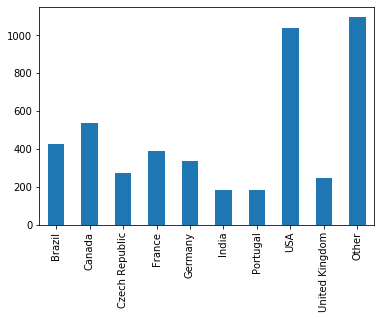

In [81]:
total_sales_chart = country_analysis_other['total_sales'].plot.bar().set_xticklabels(country_analysis_other['country_name'])


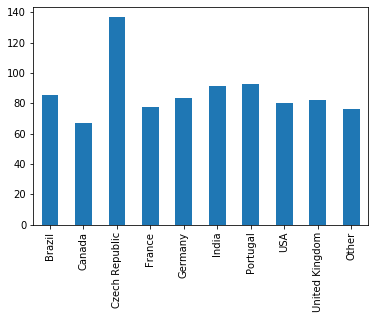

In [48]:
avg_sales_chart = country_analysis_other['average_sales_per_customer'].plot.bar().set_xticklabels(country_analysis_other['country_name'])

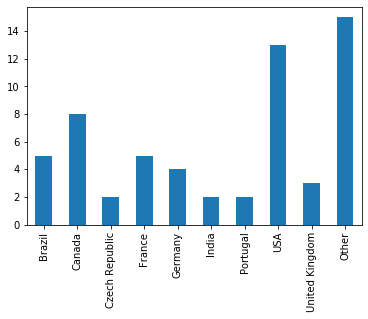

In [49]:
num_customers_chart = country_analysis_other['total_customers'].plot.bar().set_xticklabels(country_analysis_other['country_name'])

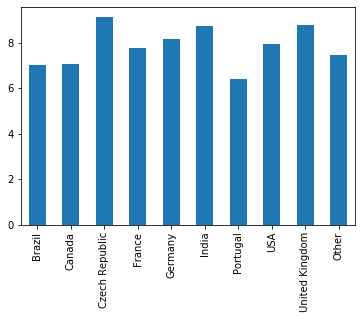

In [50]:
avg_order = country_analysis_other['avg_order_value'].plot.bar().set_xticklabels(country_analysis_other['country_name'])

Average orders are pretty similiar across all countries. However, some countries order more often than others and have more people ordering.

The USA is our best customer by far, having the most total sales and the most total customers. The next closest is Canada at roughly half the number of customers and sales. The Czech Republic has few customers but the ones that do order tend to be repeat customers. 

The 'Other' category contains all the countries with only 1 customer. Considering Australia and the UK are other english speaking countries that can be similiar to the American and Canadian audience in music taste, it might be worth spending some advertising money there to see if any growth can be spurred.

In summary, I would suggest some advertising spending in the UK, Australia, and maybe the Czech Republic to try new markets. Advertising in Canada and the USA would support existing audiences. 

### Question 4: What percentage of purchases are individual tracks vs whole albums?

We'll get lists of tracks from the invoices and comprare them to the list of tracks on the albums to see how often a whole album is purchased.

In [129]:
#compare list of track ids from album to list of track ids from invoice
#helpers:
# - get list of tracks from invoice
# - 
album_query = """
WITH 
invoice_track_list AS
(
SELECT i.invoice_id, t.name FROM track t
LEFT JOIN invoice_line il ON il.track_id=t.track_id
LEFT JOIN invoice i ON i.invoice_id=il.invoice_id
),
album_track_list AS
(
SELECT a.album_id, t.name FROM track t
LEFT JOIN album a ON a.album_id=t.album_id
),
full_albums AS (
SELECT 
    i.invoice_id, 
    i.customer_id,
    CASE 
        WHEN 
        (SELECT name FROM invoice_track_list
        WHERE invoice_id = i.invoice_id
        EXCEPT
        SELECT name FROM album_track_list
        WHERE album_id = t.album_id)
        IS NULL
        AND
        (
        SELECT name FROM album_track_list
        WHERE album_id = t.album_id
        EXCEPT
        SELECT name FROM invoice_track_list
        WHERE invoice_id = i.invoice_id) IS NULL
        THEN 1
        ELSE 0 
    END AS full_album
FROM invoice i
LEFT JOIN invoice_line il on i.invoice_id=il.invoice_id
LEFT JOIN track t on t.track_id=il.track_id
LEFT JOIN album a on a.album_id=t.album_id
GROUP BY i.invoice_id
)

SELECT * FROM full_albums
"""

album_analysis = run_query(album_query)
print(album_analysis.head(25))

    invoice_id  customer_id  full_album
0            1           18           1
1            2           30           0
2            3           40           0
3            4           18           0
4            5           27           1
5            6           31           0
6            7           49           0
7            8           59           0
8            9           18           0
9           10           31           0
10          11           38           0
11          12           42           0
12          13           35           0
13          14           25           0
14          15           44           0
15          16            1           0
16          17           20           0
17          18           24           0
18          19           10           0
19          20           43           0
20          21            9           0
21          22           35           0
22          23           53           1
23          24            4           1


In [108]:
#already run!
#save a view to use invoice_track_list everywhere
run_command("""
CREATE VIEW invoice_track_list AS
SELECT i.invoice_id, t.name FROM track t
LEFT JOIN invoice_line il ON il.track_id=t.track_id
LEFT JOIN invoice i ON i.invoice_id=il.invoice_id
""")

In [130]:
#already run!
#save a view to use album_track_list
run_command("""
CREATE VIEW album_track_list AS
SELECT a.album_id, t.name FROM track t
LEFT JOIN album a ON a.album_id=t.album_id
""")

In [131]:
#already run!
#save a view to use full_album
run_command("""
CREATE VIEW full_album AS
SELECT 
    i.invoice_id, 
    i.customer_id,
    CASE 
        WHEN 
        (SELECT name FROM invoice_track_list
        WHERE invoice_id = i.invoice_id
        EXCEPT
        SELECT name FROM album_track_list
        WHERE album_id = t.album_id)
        IS NULL
        AND
        (
        SELECT name FROM album_track_list
        WHERE album_id = t.album_id
        EXCEPT
        SELECT name FROM invoice_track_list
        WHERE invoice_id = i.invoice_id) IS NULL
        THEN 1
        ELSE 0 
    END AS full_album
FROM invoice i
LEFT JOIN invoice_line il on i.invoice_id=il.invoice_id
LEFT JOIN track t on t.track_id=il.track_id
LEFT JOIN album a on a.album_id=t.album_id
GROUP BY i.invoice_id
""")

In [127]:
#check if 5 is really a full album purchase
test_q = run_query("SELECT name FROM invoice_track_list WHERE invoice_id = 1")
print(test_q)
test_a = run_query("SELECT a.album_id, t.name FROM track t LEFT JOIN album a ON a.album_id=t.album_id WHERE a.title LIKE '%Use Your Illusion I%'")
print(test_a)

                       name
0   Right Next Door to Hell
1             Dust N' Bones
2          Live and Let Die
3      Don't Cry (Original)
4             Perfect Crime
5       You Ain't the First
6             Bad Obsession
7            Back off Bitch
8       Double Talkin' Jive
9             November Rain
10               The Garden
11           Garden of Eden
12            Don't Damn Me
13               Bad Apples
14               Dead Horse
15                     Coma
    album_id                       name
0         91    Right Next Door to Hell
1         91              Dust N' Bones
2         91           Live and Let Die
3         91       Don't Cry (Original)
4         91              Perfect Crime
5         91        You Ain't the First
6         91              Bad Obsession
7         91             Back off Bitch
8         91        Double Talkin' Jive
9         91              November Rain
10        91                 The Garden
11        91             Garden of Eden
12  

In [137]:
test_q = """
SELECT SUM(fa.full_album) total_full_albums, CAST(SUM(fa.full_album) as float)/CAST(COUNT(*)as float) pct_full_albums FROM full_album fa
"""
result = run_query(test_q)
print(result)

   total_full_albums  pct_full_albums
0                114         0.185668


Of the over 600 purchases, 114 contained full_albums, or roughly 18%. 

### Conclusion

Management can go ahead with buying only popular songs because less than 1/5th of business is geared towards full albums. 

Additional queries to continue analysis:
Which artist is used in the most playlists?
How many tracks have been purchased vs not purchased?
Is the range of tracks in the store reflective of their sales popularity?
Do protected vs non-protected media types have an effect on popularity?